# Effective Graph Paper
Code to generate "Figure 5 - Thaliana Graphs (Interaction & Effective)"

In [1]:
import numpy as np
import pandas as pd
from collections import defaultdict
import graphviz
import math
import matplotlib as mpl
mpl.rcParams['mathtext.fontset'] = 'cm'
mpl.rcParams['mathtext.rm'] = 'serif'
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from IPython.display import display, SVG
import cana
from cana.datasets.bio import THALIANA
import networkx as nx

In [2]:
def normalize(x, ab, db):
    return db[0] + (x - ab[0]) * (db[1] - db[0]) / (ab[1] - ab[0])

In [3]:
T = THALIANA()

In [4]:
SG = T.structural_graph()
EG = T.effective_graph(mode='input', bound='mean', threshold=-1)

In [5]:
dict_effconn = {nid: node.effective_connectivity(mode='node',bound='upper',norm=False) 
    for nid, node in enumerate(T.nodes,start=0) }
nx.set_node_attributes(EG, dict_effconn, 'effective_connectivity')

In [6]:
# Node Position for each one of the models
nodes = {d['label']:i for i,d in SG.nodes(data=True)}
att = defaultdict(dict)
#
# Calculates Node position in a circle.
r = 2
cx = 2.5
cy = 2.5
for deg,name in zip(range(0,360,30), ['AG', 'AP3', 'PI', 'AP2', 'TFL1', 'FUL', 'AP1', 'FT', 'EMF1', 'LFY', 'SEP', 'WUS']):
    x, y = cx+r*math.cos(math.radians(deg)), cy+r*math.sin(math.radians(deg))
    att[name]['pos'] = "{x:.2f},{y:.2f}".format(x=x,y=y)
# Nodes not on the circle. Manually position them = UFO, LUG, CLF
for name,(x,y) in zip(['UFO','LUG','CLF'], [(5.5,4.0),(5.5,2.0),(5.5,3)]):
    att[name]['pos'] = "{x:.2f},{y:.2f}".format(x=x,y=y)

## Structural Graph

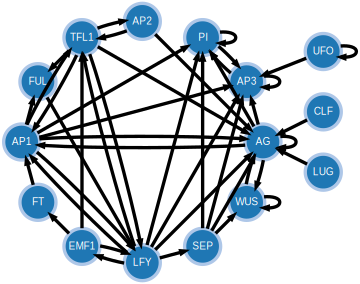

'Thaliana-SG.svg'

In [7]:
pSG = graphviz.Digraph(name='Structural Graph', engine='neato')
pSG.attr('graph', size='5,5', concentrate='false', simplify='false', overlap='true',splines='false',ratio='auto')
pSG.attr('node', pin='true', shape='circle', fixedsize='true', width='.60', color='#aec7e8', style='filled', fillcolor='#1f77b4', penwidth='4', fontname='Helvetica', fontcolor='white',fontsize='12')
pSG.attr('edge', arrowhead='normal', arrowsize='.5', color='black', penwidth='4')

for nid,d in SG.nodes(data=True):
    nid = str(nid)
    label = d['label']
    pos = att[d['label']]['pos']
    #fillcolor = 'white'
    pSG.node(nid, label=label, pos=pos)

max_penwidth = 4
for uid,vid,d in SG.edges(data=True):
    uid = str(uid)
    vid = str(vid)
    weight = '%d' % (d['weight']*100)
    pSG.edge(uid, vid, weight=weight)
    
display(SVG(pSG.pipe(format='svg')), metadata={'isolated':True})
# Export
pSG._format = 'svg'
pSG.render("Thaliana-SG", cleanup=True)

## Effective Graph

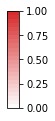

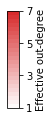

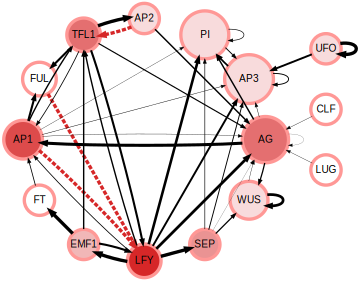

'Thaliana-EG.svg'

In [31]:
pEG = graphviz.Digraph(name='Structural Graph', engine='neato')
pEG.attr('graph', size='5,5', concentrate='false', simplify='false', overlap='true',splines='false',ratio='auto')
pEG.attr('node', pin='true', shape='circle', fixedsize='true', width='.55', color='#ff9896', style='filled', fillcolor='#515660', penwidth='4', fontname='Helvetica', fontcolor='black',fontsize='12')
pEG.attr('edge', arrowhead='normal', arrowsize='.5', color='black', penwidth='4')

max_effoutdegree = max([v for n,v in EG.out_degree()])
list_effconn = [d['effective_connectivity'] for n,d in EG.nodes(data=True)]
min_effconn, max_effconn = min(list_effconn), max(list_effconn)
#
# ColorBar
interval = np.linspace(0.0, 0.70, 256)
colors = ['white','#d62728']
cmap = LinearSegmentedColormap.from_list('custom', colors)
#norm = mpl.colors.Normalize(vmin=0, vmax=1)
norm = mpl.colors.Normalize(vmin=1, vmax=max_effoutdegree)
# Plot Colorbar
fig = plt.figure(figsize=(1.5,1.5))
ax = fig.add_axes([0.1, 0.05, 0.11, 0.9])
bounds = [1,3,5,7]
boundaries = np.linspace(1,max_effoutdegree,25).tolist()
cb = mpl.colorbar.ColorbarBase(ax, cmap=cmap, norm=norm, boundaries=boundaries,
                               ticks=bounds,spacing='uniform', orientation='vertical', format='%.0f')
cb.set_label('Effective out-degree')
display(fig)
plt.savefig('Thaliana-colorbar.svg', transparent=True)
plt.close()

# Plot Graph
for nid,d in EG.nodes(data=True):
    snid = str(nid)
    label = d['label']
    pos = att[d['label']]['pos']
    width = '{:.2f}'.format( normalize(d['effective_connectivity'], (min_effconn,max_effconn),(0.50,0.80) ) )
    att[d['label']]['width'] = width
    rgb = cmap(norm(EG.out_degree(nid)))
    hex = mpl.colors.rgb2hex(rgb)
    att[d['label']]['fillcolor'] = hex
    pEG.node(snid, label=label, pos=pos, width=width, fillcolor=hex)

max_penwidth = 4
for uid,vid,d in EG.edges(data=True):
    uid = str(uid)
    vid = str(vid)
    weight = '%d' % (d['weight']*100)
    penwidth = '%.2f' % ( d['weight'] * max_penwidth )
    if d['weight'] > 0:
        rgb = cmap(d['weight'])
        hex = mpl.colors.rgb2hex(rgb)
        pEG.edge(uid,vid, weight=weight, penwidth=penwidth)
    else:
        pEG.edge(uid,vid, style='dashed', color='#d62728')
    
display(SVG(pEG.pipe(format='svg')),metadata={'isolated':True})
# Export
pEG._format = 'svg'
pEG.render("Thaliana-EG", cleanup=True)